# Simulating semi-supervised learning on imbalanced data

In [1]:
# Create 2-D gaussians example dataset with class imbalance
import matplotlib.pyplot as plt
import numpy as np


# Define 2-D Gaussians
mean_A = [0.5, 0.5]
cov_A = [[1,0], [0,2]]
mean_B = [-2.5, 0.5]
cov_B = [[2,0], [0,1]]



In [2]:
def draw_data(NUM_A, NUM_B):
    # Draw dataset from pre-defined Gaussians
    x_A, y_A = np.random.multivariate_normal(mean_A, cov_A, NUM_A).T
    x_B, y_B = np.random.multivariate_normal(mean_B, cov_B, NUM_B).T
    data = np.vstack((np.hstack((x_A[:,np.newaxis], y_A[:,np.newaxis])),
              np.hstack((x_B[:,np.newaxis], y_B[:,np.newaxis]))))
    label = np.concatenate((-np.ones(NUM_A), np.ones(NUM_B)))
    return data, label, (x_A, y_A, x_B, y_B)

### Generate datasets

In [3]:
# Generate labeled training dataset
NUM_A = 1000
NUM_B = 50
feat_train, label_train, (x_A, y_A, x_B, y_B) = draw_data(NUM_A, NUM_B)

# Generate unlabeled data (10x more than labeled training)
NUM_A = 10000
NUM_B = 500
feat_u, _, (xu_A, yu_A, xu_B, yu_B) = draw_data(NUM_A, NUM_B)

# Generate test data (same size as original data)
NUM_A = 1000
NUM_B = 50
feat_t, label_t, (xt_A, yt_A, xt_B, yt_B) = draw_data(NUM_A, NUM_B)


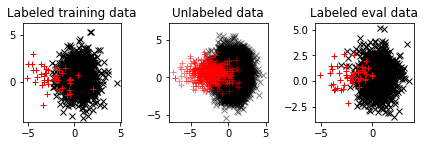

In [13]:
# Plot the data

plt.subplot(1, 3, 1)
plt.plot(x_A, y_A, 'kx')
plt.plot(x_B, y_B, 'r+')
plt.axis('square')
plt.title('Labeled training data')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(xu_A, yu_A, 'kx', alpha=0.5)
plt.plot(xu_B, yu_B, 'r+', alpha=0.5)
plt.axis('square')
plt.title('Unlabeled data')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(xt_A, yt_A, 'kx')
plt.plot(xt_B, yt_B, 'r+')
plt.axis('square')
plt.title('Labeled eval data')
plt.tight_layout()

plt.show()

### Supervised model

In [17]:
# Train a supervised model
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=0, loss='hinge', verbose=2)
model.fit(feat_train, label_train) # Fit model to labeled training data


[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=2)

### Semi-supervised model

In [21]:
# Semi-supervised learning: 

# Predict labels for unlabeled data
preds_u = model.predict(feat_u)  # y_hat
print preds_u.shape
print np.unique(preds_u)

# Training: original Data + predicted Data
model_semi = LinearSVC(random_state=0, loss='hinge', verbose=1)
X_new = np.vstack((feat_train, feat_u))
y_new = np.concatenate((label_train, preds_u))
model_semi.fit(X_new, y_new)


[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=0, tol=0.0001, verbose=1)

### Compare performance (single run)

In [22]:
# Evaluate model scores
y_hat = model.decision_function(feat_t)
y_hat_semi = model_semi.decision_function(feat_t)

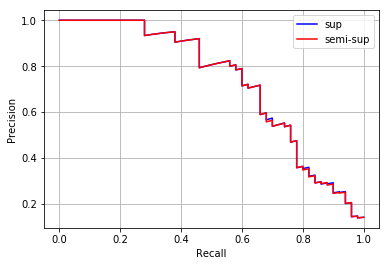

In [31]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(label_t, y_hat)
plt.plot(rec, prec, color='b', label='sup')
prec, rec, _ = precision_recall_curve(label_t, y_hat_semi)
plt.plot(rec, prec, color='r', label='semi-sup')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

## Averaged runs of semi-supervised training

In [39]:
from sklearn.metrics import average_precision_score

NUM_TRIAL = 1000

ap_sup = np.zeros(NUM_TRIAL)
ap_semi = np.zeros(NUM_TRIAL)

for i in range(NUM_TRIAL):
    # Generate labeled training dataset
    NUM_A = 1000
    NUM_B = 50
    feat_train, label_train, (x_A, y_A, x_B, y_B) = draw_data(NUM_A, NUM_B)

    # Generate unlabeled data (10x more than labeled training)
    NUM_A = 10000
    NUM_B = 500
    feat_u, _, (xu_A, yu_A, xu_B, yu_B) = draw_data(NUM_A, NUM_B)

    # Generate test data (same size as original data)
    NUM_A = 1000
    NUM_B = 50
    feat_t, label_t, (xt_A, yt_A, xt_B, yt_B) = draw_data(NUM_A, NUM_B)
    
    # Supervised model
    model = LinearSVC(random_state=0, loss='hinge')
    model.fit(feat_train, label_train) # Fit model to labeled training data
    
    # Predict labels for unlabeled data
    preds_u = model.predict(feat_u)  # y_hat

    # Semi-supervised model: original Data + predicted Data
    model_semi = LinearSVC(random_state=0, loss='hinge')
    X_new = np.vstack((feat_train, feat_u))
    y_new = np.concatenate((label_train, preds_u))
    model_semi.fit(X_new, y_new)
    
    # Evaluate model scores
    y_hat = model.decision_function(feat_t)
    y_hat_semi = model_semi.decision_function(feat_t)
    
    ap_sup[i] = average_precision_score(label_t, y_hat)
    ap_semi[i] = average_precision_score(label_t, y_hat_semi)
    

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

In [40]:
print 'AP (sup): %f +/- %f' % (np.mean(ap_sup), np.std(ap_sup))
print 'AP (semi): %f +/- %f' % (np.mean(ap_semi), np.std(ap_semi))

AP (sup): 0.790864 +/- 0.050456
AP (semi): 0.790993 +/- 0.050472


In [50]:
noise_vec = np.random.uniform(0, 1, label_train.shape)
mask= 2* (noise_vec < 0.8) - 1

print np.sum(mask==1)
print np.sum(mask==-1)

843
207


## Semi-supervised with noisy labels

In [51]:
from sklearn.metrics import average_precision_score

NUM_TRIAL = 1000
LABEL_NOISE = 0.8  # 80% correct, 20% incorrect

ap_sup = np.zeros(NUM_TRIAL)
ap_semi = np.zeros(NUM_TRIAL)

for i in range(NUM_TRIAL):
    # Generate labeled training dataset
    NUM_A = 1000
    NUM_B = 50
    feat_train, label_train, (x_A, y_A, x_B, y_B) = draw_data(NUM_A, NUM_B)
    
    # add noise to labels
    noise_vec = np.random.uniform(0, 1, label_train.shape)
    mask= 2* (noise_vec < 0.8) - 1
    

    # Generate unlabeled data (10x more than labeled training)
    NUM_A = 10000
    NUM_B = 500
    feat_u, _, (xu_A, yu_A, xu_B, yu_B) = draw_data(NUM_A, NUM_B)

    # Generate test data (same size as original data)
    NUM_A = 1000
    NUM_B = 50
    feat_t, label_t, (xt_A, yt_A, xt_B, yt_B) = draw_data(NUM_A, NUM_B)
    
    # Supervised model
    model = LinearSVC(random_state=0, loss='hinge')
    model.fit(feat_train, label_train) # Fit model to labeled training data
    
    # Predict labels for unlabeled data
    preds_u = model.predict(feat_u)  # y_hat

    # Semi-supervised model: original Data + predicted Data
    model_semi = LinearSVC(random_state=0, loss='hinge')
    X_new = np.vstack((feat_train, feat_u))
    y_new = np.concatenate((label_train, preds_u))
    model_semi.fit(X_new, y_new)
    
    # Evaluate model scores
    y_hat = model.decision_function(feat_t)
    y_hat_semi = model_semi.decision_function(feat_t)
    
    ap_sup[i] = average_precision_score(label_t, y_hat)
    ap_semi[i] = average_precision_score(label_t, y_hat_semi)
    


In [52]:
print 'AP (sup-noisy): %f +/- %f' % (np.mean(ap_sup), np.std(ap_sup))
print 'AP (semi-noisy): %f +/- %f' % (np.mean(ap_semi), np.std(ap_semi))

AP (sup-noisy): 0.790396 +/- 0.048246
AP (semi-noisy): 0.790694 +/- 0.048173
